<a href="https://colab.research.google.com/github/chrishalkias/NNSTM/blob/main/Backprop_Solution_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural network perturbation and MNIST

In [ ]:
#@title Imports and Hardware Detection (in case we need to upgrade to payed colab for more TPUs)
import numpy as np
import scipy, os, sys, time
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from tensorflow import keras
from keras import regularizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop
from scipy import stats
from google.colab import files
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
root_logdir = os.path.join(os.curdir,'my_logs')
print(f"Tensorflow v{tf.__version__}")

#%load_ext tensorboard
# import tensorflow_datasets as tfds
# import tensorflow_probability as tfp

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines (works on CPU too)
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

# To use the selected distribution strategy:
# with strategy.scope:
#    # --- define your (Keras) model here ---
#
# For distributed computing, the batch size and learning rate need to be adjusted:
# global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync # num replcas is 8 on a single TPU or N when runing on N GPUs.
# learning_rate = LEARNING_RATE * strategy.num_replicas_in_sync

Tensorflow v2.17.1
Number of accelerators:  1


# Part 1 (Backprop)

---



Implement normal back propagation for a constant width hidden layer network. Create a function that measures the accuracy of the networks and outputs the final weights so they can me used later.

In [ ]:
#@title Neural Net keras

class keras_network:
  def __init__(self):
    self.scc, self.mse = "sparse_categorical_crossentropy", "mean_squared_error"
    self.N = 28*28
  def get_run_logdir(self):
    '''Create the logs'''
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

  def initializer(self):
    '''kinda redundand but be sure on the initializations'''
    randy = keras.initializers.RandomNormal(stddev=0.1)
    weight_matrix = [[randy for _ in range(3)]]
    return weight_matrix

  def net(self, lr, epochs, phi, **kwargs):
    '''fetch data, create, compile and run the network'''
    #---dataset---
    mnist = keras.datasets.mnist
    (X_train_full, y_train_full),(X_test,y_test) = mnist.load_data()
    X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
    y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
    X_test = X_test /255.0
    #---architecture---(3 layers, last layer gets uniform and no update)
    model = keras.models.Sequential()
    flatten = keras.layers.Flatten(input_shape=[28,28])
    layer1 = keras.layers.Dense(units=self.N, activation=phi[0], use_bias=False)
    layer2 = keras.layers.Dense(units=self.N, activation =phi[1], use_bias=False)
    layer3 = keras.layers.Dense(units=10, activation =phi[2], use_bias=False, kernel_initializer='glorot_uniform')
    layer3.trainable=False
    model.add(flatten)
    model.add(layer1)
    model.add(layer2)
    model.add(layer3)
    #---compile---
    model_summary, model_layers  = model.summary(), model.layers
    opt = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss=self.scc, optimizer = opt, metrics=["accuracy"])
    #---logs---
    run_logdir = self.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    history = model.fit(X_train, y_train, epochs=epochs,callbacks = [tensorboard_cb], validation_data =(X_valid, y_valid))
    if kwargs.get("plot") == True:
      pd.DataFrame(history.history).plot(figsize = (8,5))
      plt.grid(True)
      plt.gca().set_ylim(0,1)
      plt.show()
    #--weights--
    return {'w1': model.layers[1].get_weights(),
            'w2': model.layers[2].get_weights(),
            'w3': model.layers[3].get_weights()}

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           7,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,237,152 (4.72 MB)

 Trainable params: 1,229,312 (4.69 MB)

 Non-trainable params: 7,840 (30.62 KB)

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8079 - loss: 0.7406 - val_accuracy: 0.9062 - val_loss: 0.3386
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8999 - loss: 0.3524 - val_accuracy: 0.9152 - val_loss: 0.3034
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9086 - loss: 0.3221 - val_accuracy: 0.9204 - val_loss: 0.2902
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9160 - loss: 0.3018 - val_accuracy: 0.9222 - val_loss: 0.2861
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9177 - loss: 0.2966 - val_accuracy: 0.9254 - val_loss: 0.2795
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9179 - loss: 0.2961 - val_accuracy: 0.9268 - val_loss: 0.2758
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9207 - loss: 0.2865 - val_accuracy: 0.9254 - val_loss: 0.2717
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9219 - loss: 0.2795 

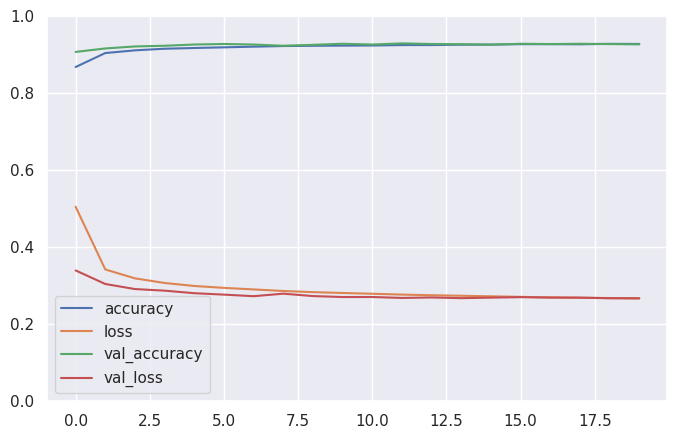

In [ ]:
experiment = keras_network()
weights = experiment.net(0.01, 20, ["linear","linear","softmax"], plot = True);

# Part 2 (Exact prior)

Now we implement the exact prior for a two layer network

In [ ]:
#@title ZVP formula for two layer network

class ZVP():
  def __init__(self):
    self.N=100
    self.temp = 1
    self.sigma = 1/self.N**2 # *self.temp #?

  def mnist(self,boundary:str) -> dict:
    '''loads mnist and outputs a subset of it'''
    mnist = keras.datasets.mnist
    (X_train_full, y_train_full),(X_test,y_test) = mnist.load_data()
    X_train_full = X_train_full / 255.0
    X_test = X_test / 255.0
    if boundary == 'x':
      return X_test
    elif boundary == 'y':
      return y_test

  def prior(self,h, x) -> np.array:
    '''computes the prior from the ZVP formula, this is the gist of it'''
    norm_x = np.linalg.norm(x)
    gamma = scipy.special.gamma(self.N/2)
    prefactor = 1 #(4*np.pi*(self.sigma**4)*norm_x**2)**(-self.N/2) * (2/gamma)
    k0 = scipy.special.kn(0, h /(self.sigma * norm_x), out=None)
    #print(f"|x|= {norm_x:.3f}\nΓ(N/2) = {gamma}\nprefactor = {prefactor}\nk0 = {k0[0::10]}")
    return prefactor * k0

  def likelihood(self,y, x,h) -> float:
    '''computes the likelihood p(y|h,x) = a gaussian centered around y???'''
    #temperature should go in here, but how?
    last_layer_weights = np.random.uniform(self.N)
    softmax = scipy.special.softmax(h)
    f = np.sum(last_layer_weights * softmax)
    loss = 0.5*(f-y)**2
    print(f"True label = {y} \nPredictor value = {f:.3f}\nloss = {loss:.3f}\n")
    return np.exp(-loss)

  def p_xy(self):
    '''normalization'''
    pass

In [ ]:
#@title Plot of the prior
def runZVP():
  ''' Calls upon the ZVP class to make the magic happen'''
  nn=ZVP()
  h_d = np.linspace(0,1,784)
  weights = np.random.uniform(size=nn.N) #these we should get from backprop!!!
  p_likelihood = nn.likelihood(nn.mnist('y')[0], nn.mnist('x')[0], weights)
  p_prior = nn.prior(h_d, nn.mnist('x'))

  #---Prints and Plots---
  print(f"Number of neurons per layer: {nn.N}")
  print(f"|h_d|/σ²|x|={np.linalg.norm(h_d / (1/nn.N**2)*np.linalg.norm(nn.mnist('x')))}")
  #print(f"likelihood = {p_likelihood}\n prior = {p_prior[0::25]}\n")
  plt.title(f'Prior density $p_2({{h_d}}| {{x}})$, N={nn.N}')
  plt.xlabel(r'$|{h_d}|$')
  plt.plot(h_d, p_prior, color="red")
  plt.show()
  return p_prior

True label = 7 
Predictor value = 64.174
loss = 1634.414

Number of neurons per layer: 100
|h_d|/σ²|x|=152850429.81898776


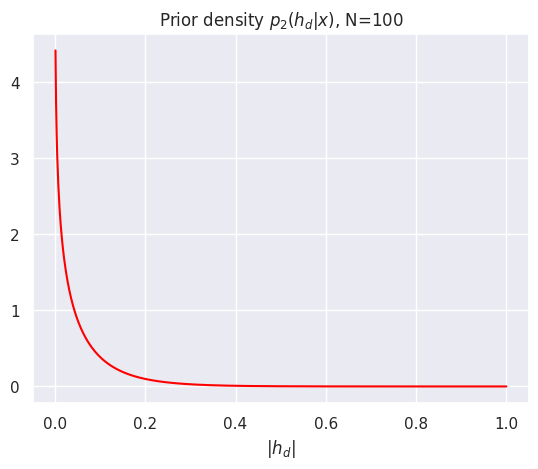

In [ ]:
exact_prior = runZVP();

In [ ]:
#@title Compute the network by the aneealed state
def manual_NN():
  '''Sets up a neural net I/O mapping (gotta run the NN first!!)'''
  nn = ZVP()
  x = (nn.mnist('x')[0]).flatten()
  #print(f"Dims check {len((np.array(weights['w1'])).flatten()) == len(x)**2}")
  layer1 = np.dot(np.array(weights['w1']), x)
  layer2 = np.dot(np.array(weights['w2']), layer1.flatten())
  return layer2
  layer3 = np.dot(np.array(weights['w3']), layer2.flatten())
  return layer3

def distribution():
  ''' Calls manual_NN & Creates prior densities out of the manual_NN()'''
  from scipy.stats import gaussian_kde
  final = manual_NN().flatten() #call manual_NN
  dist_space = np.linspace(0, max(final), 100)
  kde = gaussian_kde(final)
  plt.title(f'KDE for Probability distribution of $h_2$ for N={28*28}')
  plt.xlabel(r'$|{h_d}|$')
  plt.ylabel('count')
  plt.plot(dist_space, kde(dist_space))
  #return kde(dist_space)
  return final

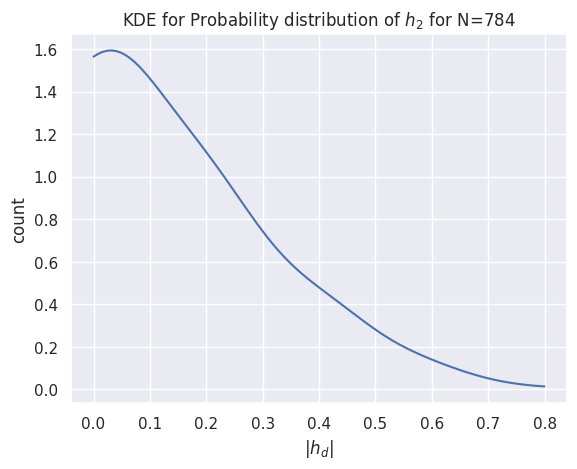

In [ ]:
annealed_prior = distribution();

In [ ]:
def distinguish_PD(p, q):
  ''' Use Jensen–Shannon divergence to derive a distance metric between the two PDs'''
  return scipy.spatial.distance.jensenshannon(p, q)

#first we have to transform the prior density in
distance = distinguish_PD(np.abs(exact_prior[1:10]/np.sum(exact_prior[1:10])),
            np.abs(annealed_prior[1:10]/ np.sum(annealed_prior[1:10])))
print(f'Jensen-Shannon divergence between annealed and exact prior = {distance}')

Jensen-Shannon divergence between annealed and exact prior = 0.31846275821581965
